In [1]:
#U-Net for prediction of peak positions

import scipy.io
from scipy.sparse import coo_matrix
import pandas as pd
import matplotlib.pyplot as plt
import time
import cv2
import numpy as np

from sys import getsizeof

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

from MyDataset import MyDataset
import random

from statsmodels.stats.proportion import proportion_confint

print(torch.__version__)

1.12.1


In [2]:
torch.set_default_dtype(torch.float64)

images = torch.load('256x256_images_100_percent.pt')
labels = torch.load('256x256_masks_100_percent.pt')

In [3]:
# number of epochs to train the model
n_epochs = 100
# Learning rate of optimizer
learning_rate = 0.01
# Batch size of data loaders and batch size used when training model
batch_size = 48
#dropout rate
dropout = 0.5

In [5]:
print(len(images))
print(len(labels))

random.Random(10).shuffle(images) # shuffling with seed
random.Random(10).shuffle(labels) 

#images=images[0:500]
#labels=labels[0:500]

size = len(images)

dataset = MyDataset(images,labels)

split_indices = list(range(0,size))

train_idx=split_indices[0:round(0.70*size)]
val_idx=split_indices[round(0.70*size):round(0.85*size)]
test_idx=split_indices[round(0.85*size):]
print(train_idx)
print(val_idx)
print(test_idx)

train_dataset=MyDataset([images[i] for i in train_idx],[labels[i] for i in train_idx])
val_dataset=MyDataset([images[i] for i in val_idx],[labels[i] for i in val_idx])
test_dataset=MyDataset([images[i] for i in test_idx],[labels[i] for i in test_idx])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

for data, target in train_loader:
    print(data.shape)
    print(target.shape)
    
for data, target in test_loader:
    print(data.shape)
    print(target.shape)
    

3906
3906
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

torch.Size([46, 1, 256, 256])
torch.Size([46, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([

In [6]:
# define the CNN architecture

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
            
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x
    
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p
    
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(1, 16)
        self.e2 = encoder_block(16, 32)
        self.e3 = encoder_block(32, 64)
        self.e4 = encoder_block(64, 128)
        """ Bottleneck """
        self.b = conv_block(128, 256)
        """ Decoder """
        self.d1 = decoder_block(256, 128)
        self.d2 = decoder_block(128, 64)
        self.d3 = decoder_block(64, 32)
        self.d4 = decoder_block(32, 16)
        """ Classifier """
        self.outputs = nn.Conv2d(16, 1, kernel_size=1, padding=0)
        
    def forward(self, inputs):
        """ Encoder """
        #print('inputs:' + str(inputs.shape))
        s1, p1 = self.e1(inputs)
        #print('s1:' + str(s1.shape))
        #print('p1:' + str(p1.shape))
        s2, p2 = self.e2(p1)
        #print('s2:' + str(s2.shape))
        #print('p2:' + str(p2.shape))
        s3, p3 = self.e3(p2)
        #print('s3:' + str(s3.shape))
        #print('p3:' + str(p3.shape))
        s4, p4 = self.e4(p3)
        #print('s4:' + str(s4.shape))
        #print('p4:' + str(p4.shape))
        """ Bottleneck """
        b = self.b(p4)
        #print('b:' + str(b.shape))
        """ Decoder """
        d1 = self.d1(b, s4)
        #print('d1:' + str(d1.shape))
        d2 = self.d2(d1, s3)
        #print('d2:' + str(d2.shape))
        d3 = self.d3(d2, s2)
        #print('d3:' + str(d3.shape))
        d4 = self.d4(d3, s1)
        #print('d4:' + str(d4.shape))
        """ Classifier """
        x = self.outputs(d4)
        outputs = torch.sigmoid(x)
        print('outputs:' + str(outputs.shape))
        return outputs        

In [169]:
# create a complete CNN
torch.manual_seed(10) # set seed before creating model
model = unet()
        
#print(model.state_dict()['fc1.weight'])

print(model)
    
# specify loss function (Binary cross entropy)
criterion = nn.MSELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(

In [8]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    model.cuda()
    criterion.cuda()
    print('CUDA is available!  Training on GPU ...')

valid_loss_min = np.Inf # track change in validation loss

train_loss= [0.0] * n_epochs
valid_loss= [0.0] * n_epochs

for epoch in range(0, n_epochs):

    # keep track of training and validation loss
    #train_loss[epoch] = 0.0
    #valid_loss[epoch] = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        data=data.to_dense() # model needs dense matrices as input
        target=target.to_dense()
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        output = output.to(torch.float64) #
        target = target.to(torch.float64) #
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[epoch] += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        data=data.to_dense() # model needs dense matrices as input
        target=target.to_dense() # model needs dense matrices as input
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        
        output = output.to(torch.float64) 
        target = target.to(torch.float64) 
        
        #print(output[0][output[0] >= 0.5])
        #print(target[0][target[0] != 0])
        #print(output)
        #print(target)
        #maxOutputs = []
        #for i in range(output.shape[0]):
        #    maxOutputs.append(output[i].max().cpu().detach().numpy() )
        #print(maxOutputs)
        
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss[epoch] += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss[epoch] = train_loss[epoch]/len(train_loader.sampler)
    valid_loss[epoch] = valid_loss[epoch]/len(valid_loader.sampler)
        
    # print training/validation statistics
    print_train_loss=train_loss[epoch]
    print_valid_loss=valid_loss[epoch]
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, print_train_loss, print_valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss[epoch] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        print_valid_loss))
        torch.save(model.state_dict(), 'my_unet_model.pt')
        valid_loss_min = valid_loss[epoch]

CUDA is available!  Training on GPU ...
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:to

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 3 	Training Loss: 0.000758 	Validation Loss: 0.000701
Validation loss decreased (0.000797 --> 0.000701).  Saving model ...
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 25

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 6 	Training Loss: 0.000542 	Validation Loss: 0.000488
Validation loss decreased (0.000558 --> 0.000488).  Saving model ...
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 25

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 9 	Training Loss: 0.000383 	Validation Loss: 0.000370
Validation loss decreased (0.000381 --> 0.000370).  Saving model ...
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 25

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 12 	Training Loss: 0.000338 	Validation Loss: 0.000364
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 15 	Training Loss: 0.000313 	Validation Loss: 0.000327
Validation loss decreased (0.000332 --> 0.000327).  Saving model ...
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 2

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([46, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 18 	Training Loss: 0.000299 	Validation Loss: 0.000318
Validation loss decreased (0.000323 --> 0.000318).  Saving model ...
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 2

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([46, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 21 	Training Loss: 0.000282 	Validation Loss: 0.000310
Validation loss decreased (0.000314 --> 0.000310).  Saving model ...
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 2

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([46, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 24 	Training Loss: 0.000269 	Validation Loss: 0.000326
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([46, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 27 	Training Loss: 0.000264 	Validation Loss: 0.000338
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([46, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 30 	Training Loss: 0.000253 	Validation Loss: 0.000353
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([46, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 33 	Training Loss: 0.000248 	Validation Loss: 0.000324
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([46, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 36 	Training Loss: 0.000251 	Validation Loss: 0.000330
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([46, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 39 	Training Loss: 0.000231 	Validation Loss: 0.000316
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([46, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 42 	Training Loss: 0.000221 	Validation Loss: 0.000326
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([46, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 45 	Training Loss: 0.000212 	Validation Loss: 0.000335
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([46, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 48 	Training Loss: 0.000203 	Validation Loss: 0.000336
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([46, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 51 	Training Loss: 0.000193 	Validation Loss: 0.000326
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 54 	Training Loss: 0.000170 	Validation Loss: 0.000351
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 57 	Training Loss: 0.000167 	Validation Loss: 0.000365
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 60 	Training Loss: 0.000162 	Validation Loss: 0.000345
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 63 	Training Loss: 0.000151 	Validation Loss: 0.000355
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([10, 1, 256, 256])
Epoch: 66 	Training Loss: 0.000142 	Validation Loss: 0.000373
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1, 256, 256])
outputs:torch.Size([48, 1,

KeyboardInterrupt: 

NameError: name 'train_loss' is not defined

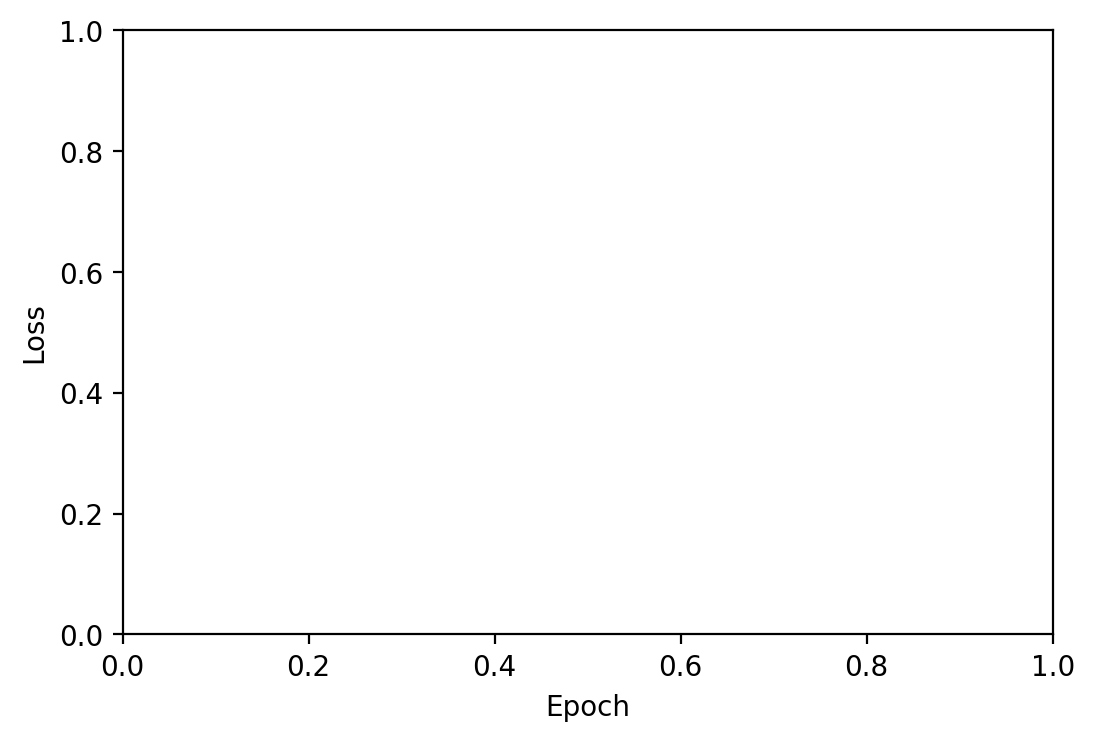

In [7]:
fig, ax = plt.subplots()
fig.set_dpi(200)
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
line1 = plt.plot(np.linspace(1, n_epochs, num=n_epochs), train_loss)
line2 = plt.plot(np.linspace(1, n_epochs, num=n_epochs), valid_loss)
plt.legend(["train loss", "valid loss"])
#plt.xticks(np.arange(0, n_epochs, 1))

In [8]:
#model_1 = unet()
#model_1.load_state_dict(torch.load('my_unet_model_0.001217_sigmoid_BCE_256f_3906d.pt'))
#model_1.eval()

model_2 = unet()
model_2.load_state_dict(torch.load('my_unet_model_0.000310_sigmoid_MSE_256f_3906d.pt'))
model_2.eval()


#if train_on_gpu:
#model.cuda()

#outputList_1 = []
outputList_2 = []
targetList = []
dataList = []


for data, target in test_loader:
        data=data.to_dense() # model needs dense matrices as input
        target=target.to_dense()
        # move tensors to GPU if CUDA is available
        #if train_on_gpu:
        #    data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        #output_1 = model_1(data)
        # calculate the batch loss
        #output_1 = output_1.to(torch.float64) #
        
        output_2 = model_2(data)
        # calculate the batch loss
        output_2 = output_2.to(torch.float64) #
        
        
        target = target.to(torch.float64) #

        #output_1 = output_1.detach().numpy()
        output_2 = output_2.detach().numpy()
        target = target.detach().numpy()
        
        #print(output.shape)
        #print(target.shape)
        
        #outputList_1.append(output_1)
        outputList_2.append(output_2)
        targetList.append(target)
        dataList.append(data)
            

outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
o

outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
o

outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
outputs:torch.Size([1, 1, 256, 256])
o

In [180]:
imageWithCorrectPeak=0
for i in range(len(outputList_2)):
    correctPeak=0
    myTarget=targetList[i]
    myTarget=myTarget.flatten()
    myOutput_2=outputList_2[i]
    myOutput_2=myOutput_2.flatten()
    for j in range(myTarget.size):
        if (myTarget[j] == 1):
            if (myOutput_2[j] > 0.5):
                correctPeak +=1
                break
    if correctPeak > 0:
        imageWithCorrectPeak +=1

print(str(imageWithCorrectPeak/len(outputList_2)))



0.7849829351535836


In [143]:
#https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
truePositive=0
falsePositive=0
falseNegative=0
total=0
for i in range(len(outputList_2)):
    myTarget=targetList[i]
    myTarget=myTarget.flatten()
    myOutput_2=outputList_2[i]
    myOutput_2=myOutput_2.flatten()
    for j in range(myTarget.size):
        total +=1
        if (myTarget[j] == 1):
            if (myOutput_2[j] >= 0.5):
                truePositive +=1
            else:
                falseNegative +=1
        elif (myOutput_2[j] >= 0.5):
            falsePositive +=1
                
print(str(truePositive))
print(str(falsePositive))
print(str(falseNegative))
print(str(total))

precision = truePositive / (truePositive + falsePositive)
recall = truePositive / (truePositive + falseNegative)
f1_measure = (2 * precision * recall) / (precision + recall)

print(str(precision))
print(str(recall))
print(str(f1_measure))

15725
5320
10097
38404096
0.747208363031599
0.6089768414530246
0.6710478588345745


MSE
peaks:70
correctPeak:58
falsePeak:29


Text(0.5, 1.0, 'Output')

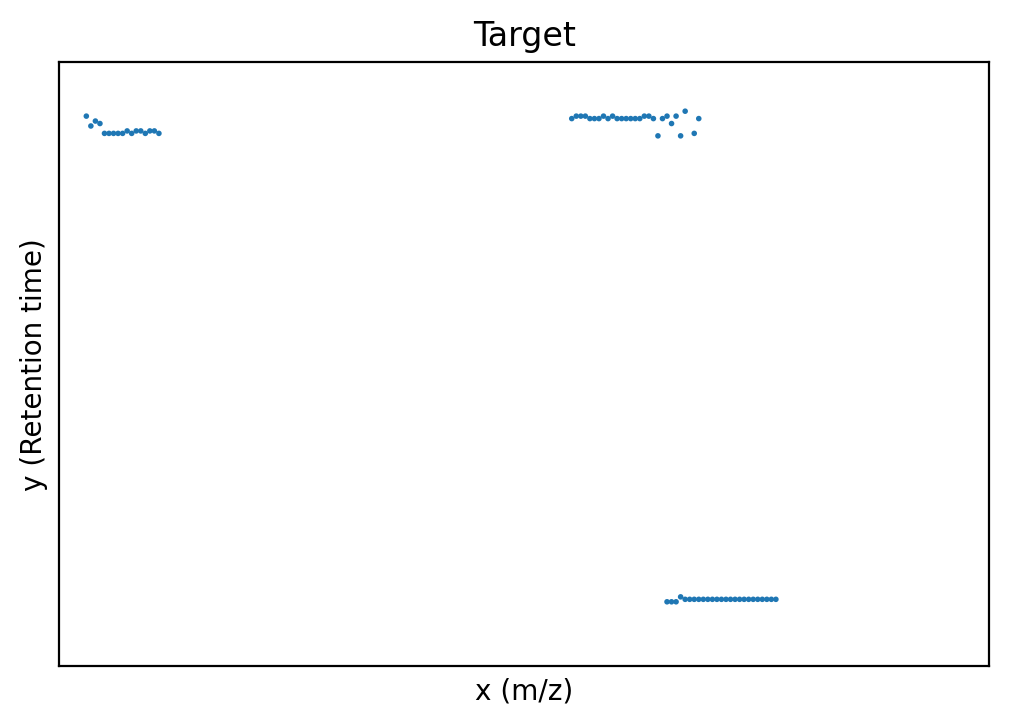

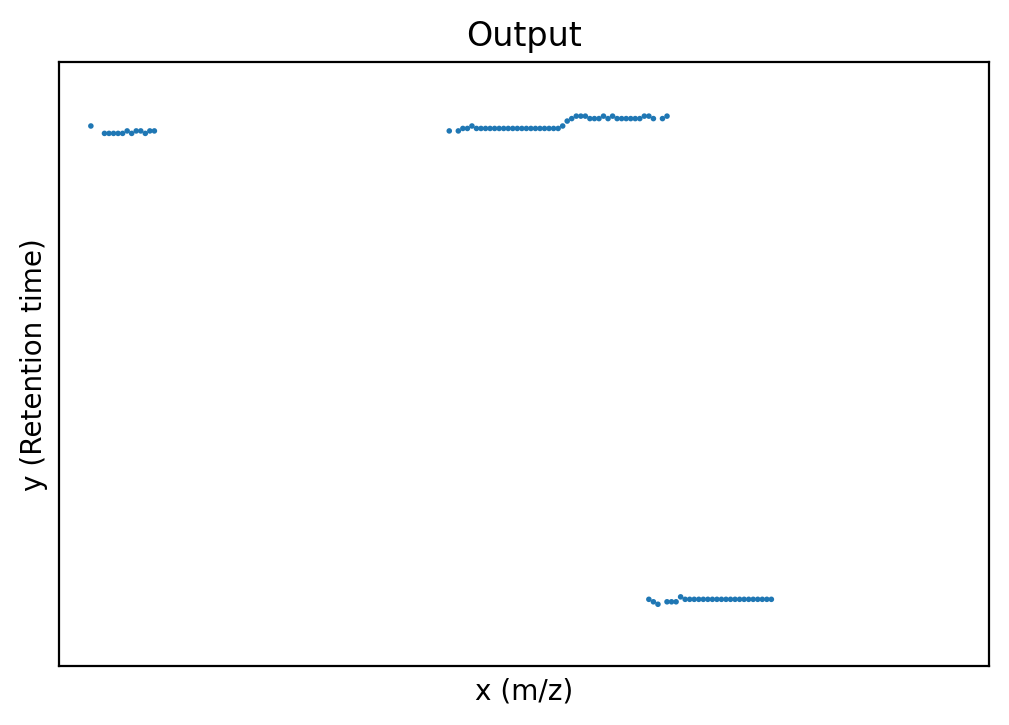

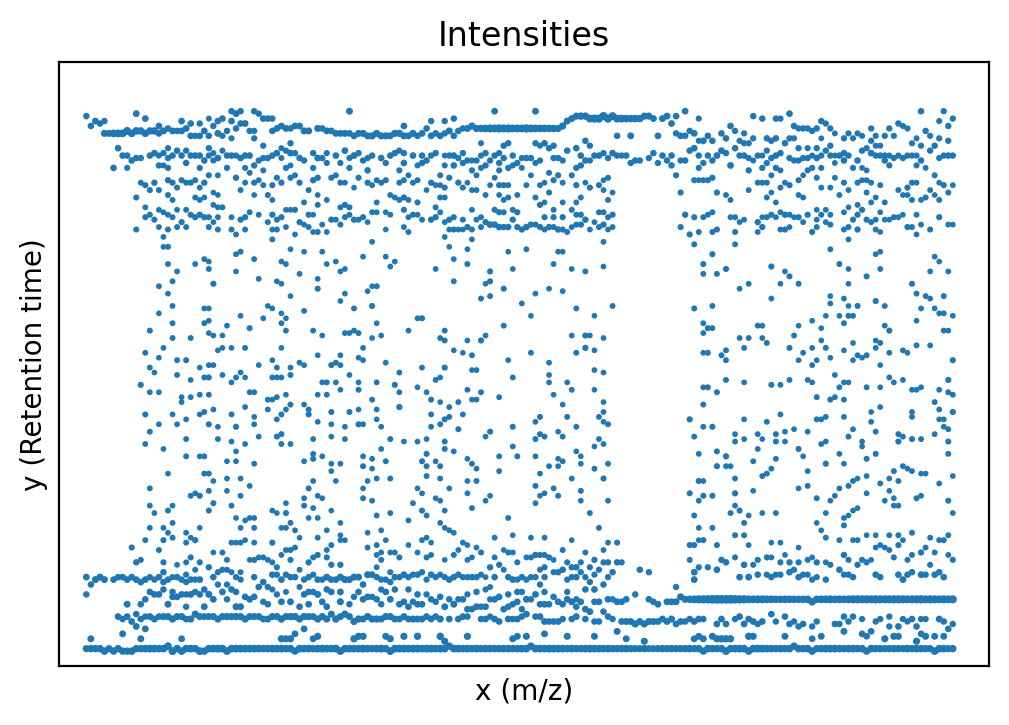

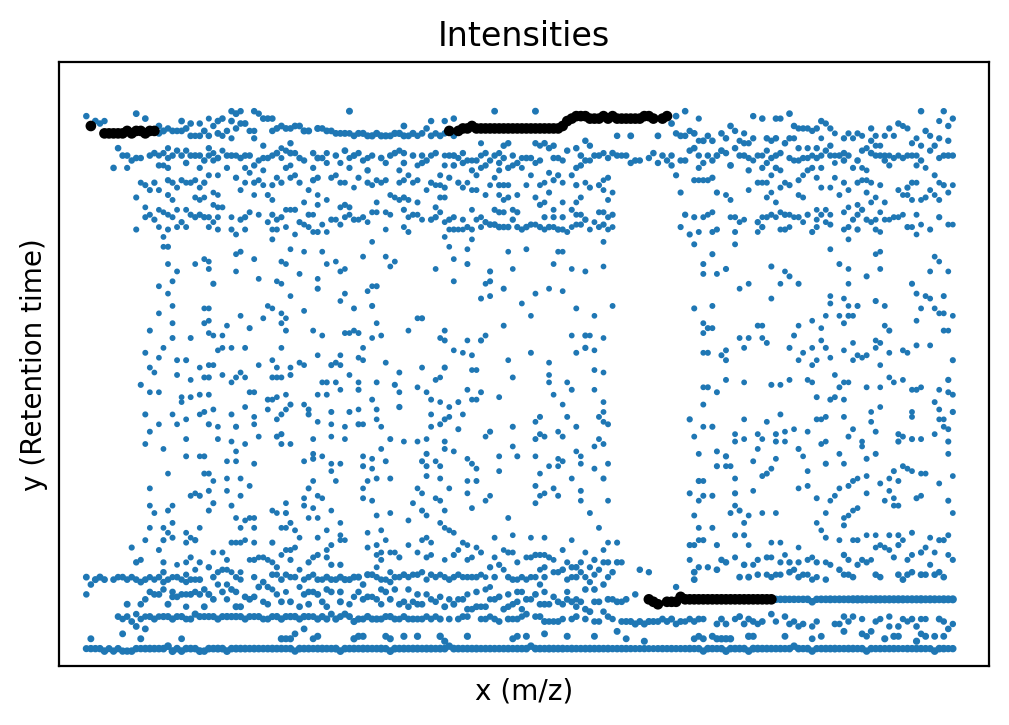

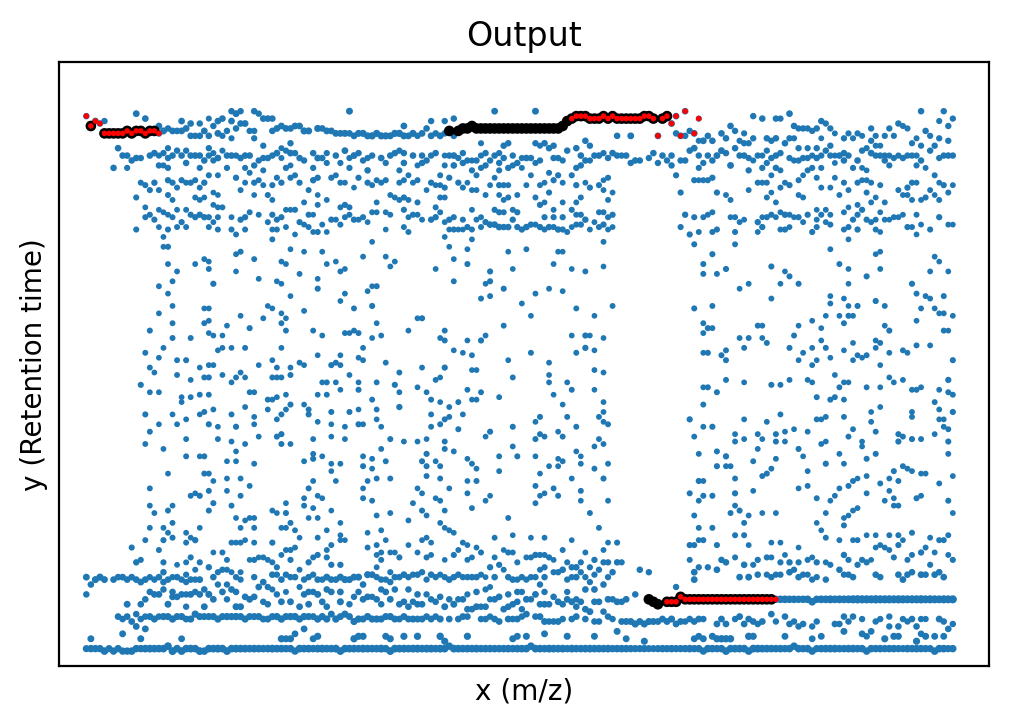

In [18]:
image_nr = 97

myTarget=targetList[image_nr]

#myOutput_1=outputList_1[image_nr]

myOutput_2=outputList_2[image_nr]

myData=dataList[image_nr]


#print(myTarget[myTarget != 0.5])
#print(myOutput_1[myOutput_1 >= 0.5])
#print(myOutput_2[myOutput_2 >= 0.5])

myTarget=myTarget.flatten()
#print(myTarget.shape)

#myOutput_1=myOutput_1.flatten()
#print(myOutput.shape)

myOutput_2=myOutput_2.flatten()
#print(myOutput.shape)

#cutOff = min(0.5,myOutput_2.max())
cutOff = 0.5

#myOutput_1[myOutput_1 >= cutOff] = 1
#myOutput_1[myOutput_1 < cutOff] = 0
myOutput_2[myOutput_2 >= cutOff] = 1
myOutput_2[myOutput_2 < cutOff] = 0

#peaks=0
#correctPeak=0
#falsePeak=0
#for j in range(myTarget.size):
#    if (myTarget[j] == 1):
#       peaks += 1
#        if (myOutput_1[j] > 0.5):
#            correctPeak +=1
#    else:
#        if (myOutput_1[j] > 0.5):
#            falsePeak += 1

#print('BCE')
#print('peaks:' + str(peaks))
#print('correctPeak:' + str(correctPeak))
#print('falsePeak:' + str(falsePeak))


peaks=0
correctPeak=0
falsePeak=0
for j in range(myTarget.size):
    if (myTarget[j] == 1):
        peaks += 1
        if (myOutput_2[j] > 0.5):
            correctPeak +=1
    else:
        if (myOutput_2[j] > 0.5):
            falsePeak += 1

print('MSE')
print('peaks:' + str(peaks))
print('correctPeak:' + str(correctPeak))
print('falsePeak:' + str(falsePeak))



ls=np.linspace(1,256,256) 
x_axis=np.tile(ls,256) 
#print(x_axis.shape)
#print(x_axis)

ls=np.linspace(1,256,256) 
y_axis=np.repeat(ls,256) 
#print(y_axis.shape)
#print(y_axis)

fig, ax = plt.subplots()
fig.set_dpi(200)
plt.xlabel('x (m/z)')
plt.ylabel('y (Retention time)')
plt.xlim([-5, 200])
plt.ylim([-5, 240])
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)
plt.scatter(x_axis, y_axis, s=myTarget)
ax.set_title('Target')

#fig, ax = plt.subplots()
#fig.set_dpi(200)
#plt.scatter(x_axis, y_axis, s=myOutput_1)
#ax.set_title('Output BCE')

fig, ax = plt.subplots()
fig.set_dpi(200)
plt.xlim([-5, 200])
plt.ylim([-5, 240])
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)
plt.xlabel('x (m/z)')
plt.ylabel('y (Retention time)')
plt.scatter(x_axis, y_axis, s=myOutput_2)
ax.set_title('Output') #MSE

fig, ax = plt.subplots()
fig.set_dpi(200)
plt.xlim([-5, 200])
plt.ylim([-5, 240])
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)
plt.xlabel('x (m/z)')
plt.ylabel('y (Retention time)')
plt.scatter(x_axis, y_axis, (0.2*myData)**1)
ax.set_title('Intensities')

fig, ax = plt.subplots()
fig.set_dpi(200)
plt.xlim([-5, 200])
plt.ylim([-5, 240])
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)
plt.xlabel('x (m/z)')
plt.ylabel('y (Retention time)')
plt.scatter(x_axis, y_axis, (0.2*myData)**1)
plt.scatter(x_axis, y_axis, s=8*myOutput_2, color='k')
ax.set_title('Intensities')

fig, ax = plt.subplots()
fig.set_dpi(200)
plt.xlim([-5, 200])
plt.ylim([-5, 240])
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)
plt.xlabel('x (m/z)')
plt.ylabel('y (Retention time)')
plt.scatter(x_axis, y_axis, (0.2*myData)**1)
plt.scatter(x_axis, y_axis, s=8*myOutput_2, color='k')
plt.scatter(x_axis, y_axis, s=1*myTarget, color='r')
ax.set_title('Output')
              
              
                